<ipython-input-14-37dd98ac1e8f>:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='action', data=df, palette='Set2')


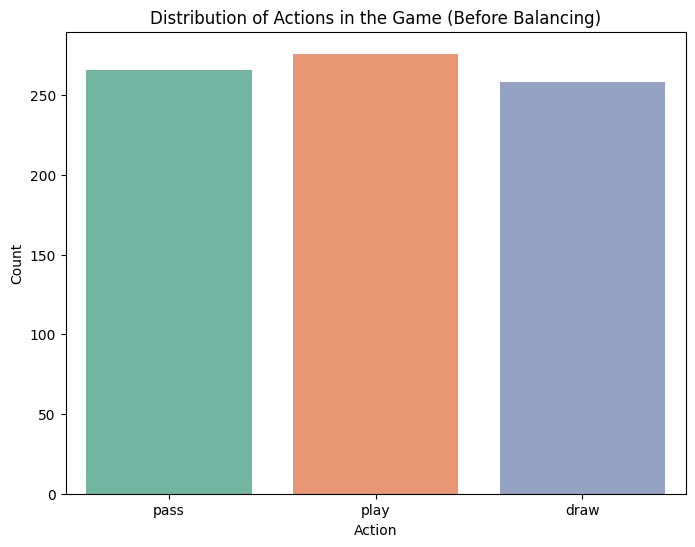

<ipython-input-14-37dd98ac1e8f>:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='Set2')


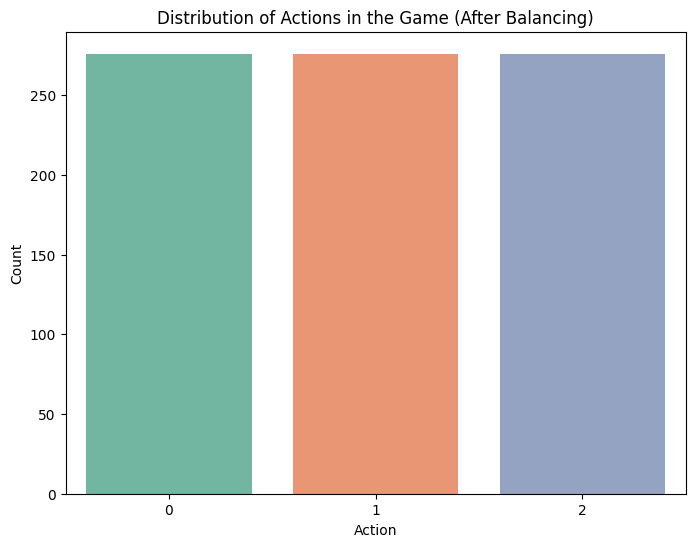

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 - 7s - 357ms/step - accuracy: 0.3369 - loss: 1.3139 - val_accuracy: 0.3614 - val_loss: 1.0980
Epoch 2/50
21/21 - 1s - 44ms/step - accuracy: 0.3172 - loss: 1.1633 - val_accuracy: 0.3133 - val_loss: 1.1248
Epoch 3/50
21/21 - 0s - 17ms/step - accuracy: 0.3444 - loss: 1.1363 - val_accuracy: 0.3193 - val_loss: 1.1064
Epoch 4/50
21/21 - 1s - 34ms/step - accuracy: 0.3353 - loss: 1.1379 - val_accuracy: 0.4096 - val_loss: 1.0964
Epoch 5/50
21/21 - 1s - 30ms/step - accuracy: 0.3369 - loss: 1.1323 - val_accuracy: 0.3494 - val_loss: 1.0981
Epoch 6/50
21/21 - 0s - 14ms/step - accuracy: 0.3444 - loss: 1.1242 - val_accuracy: 0.3614 - val_loss: 1.1019
Epoch 7/50
21/21 - 0s - 12ms/step - accuracy: 0.3369 - loss: 1.1062 - val_accuracy: 0.3916 - val_loss: 1.0962
Epoch 8/50
21/21 - 0s - 11ms/step - accuracy: 0.3535 - loss: 1.1149 - val_accuracy: 0.3133 - val_loss: 1.1500
Epoch 9/50
21/21 - 0s - 14ms/step - accuracy: 0.3474 - loss: 1.1187 - val_accuracy: 0.3614 - val_loss: 1.0942
Epoch 10/

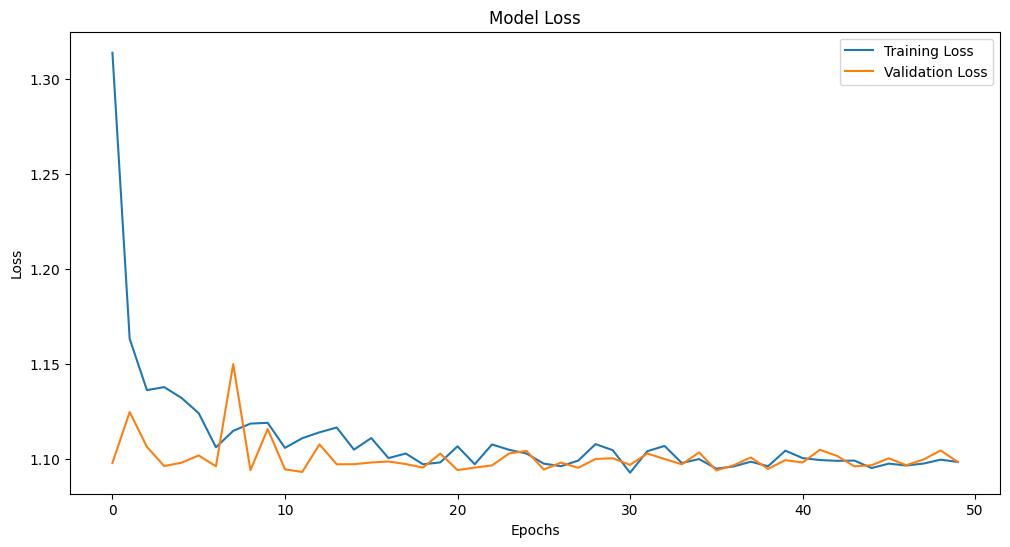

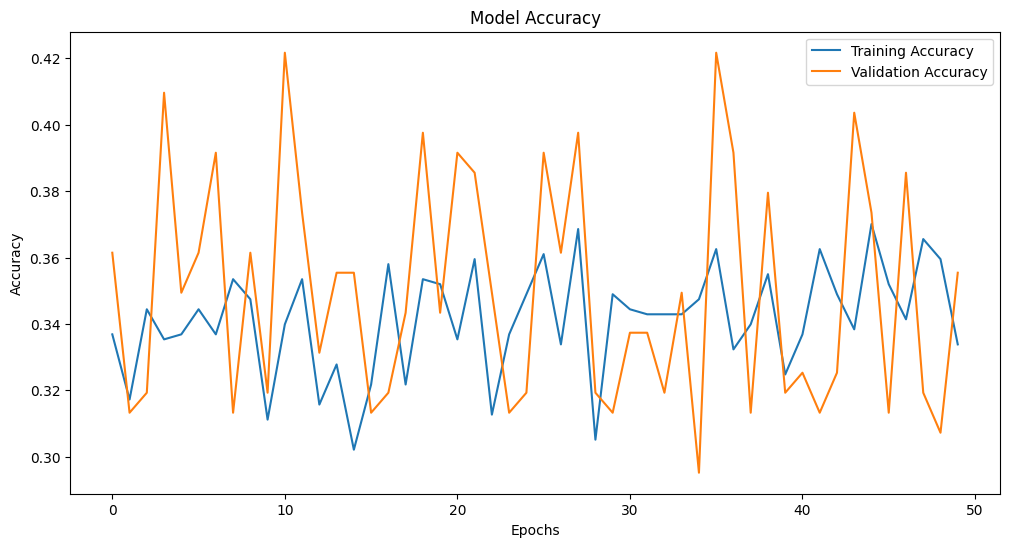

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3400 - loss: 1.1011 
Test Accuracy: 35.54%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predictions for first 5 test samples: ['draw' 'draw' 'draw' 'draw' 'play']


In [ ]:
import random
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique

# Define constants
SUITS = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']

# Create a deck of cards
def create_deck():
    return [f'{rank} of {suit}' for suit in SUITS for rank in RANKS]

# Shuffle deck
def shuffle_deck(deck):
    random.shuffle(deck)

# Simulate a game step
def simulate_game_step(player_hand, discard_pile, action, deck):
    if action == 'play':
        if player_hand:
            card_played = random.choice(player_hand)
            player_hand.remove(card_played)
            discard_pile.append(card_played)
        else:
            return player_hand, discard_pile, deck, 'pass'
    elif action == 'draw':
        if deck:
            card_drawn = deck.pop()
            player_hand.append(card_drawn)
        else:
            return player_hand, discard_pile, deck, 'pass'
    elif action == 'pass':
        pass
    return player_hand, discard_pile, deck, action

# Function to simulate a complete game and generate a dataset
def simulate_game(player_count=4, game_length=20):
    deck = create_deck()
    shuffle_deck(deck)

    hands = {f'Player_{i}': [deck.pop() for _ in range(5)] for i in range(player_count)}
    discard_pile = []

    data = []

    for turn in range(game_length):
        for player, hand in hands.items():
            state = {
                'turn': turn,
                'player_hand': hand,
                'discard_pile': discard_pile,
                'remaining_deck': len(deck)
            }

            action = random.choice(['play', 'draw', 'pass'])
            new_hand, new_discard_pile, new_deck, applied_action = simulate_game_step(hand, discard_pile, action, deck)

            data.append({
                'turn': turn,
                'player': player,
                'player_hand': ' '.join(new_hand),
                'discard_pile': ' '.join(new_discard_pile),
                'action': applied_action,
                'remaining_deck': len(new_deck)
            })

            hands[player] = new_hand
            discard_pile = new_discard_pile
            deck = new_deck

    return pd.DataFrame(data)

# Generate a dataset by simulating games
def generate_dataset(num_games=100):
    all_data = []
    for _ in range(num_games):
        game_data = simulate_game()
        all_data.append(game_data)
    return pd.concat(all_data, ignore_index=True)

# Generate the dataset
df = generate_dataset(num_games=10)  # Simulate 10 games for testing

# Data Preprocessing
# Encode actions
action_encoder = LabelEncoder()
df['action_encoded'] = action_encoder.fit_transform(df['action'])

# Convert player hands to numerical data
def hand_to_numeric(hand):
    card_values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}
    suit_values = {'Hearts': 0, 'Diamonds': 1, 'Clubs': 2, 'Spades': 3}

    hand_vector = np.zeros(52)

    if isinstance(hand, str) and hand:
        for card in hand.split(' '):
            if ' of ' in card:
                rank, suit = card.split(' of ')
                if rank in card_values and suit in suit_values:
                    rank_idx = card_values[rank] - 2
                    suit_idx = suit_values[suit]
                    hand_vector[rank_idx + suit_idx * 13] = 1

    return hand_vector

df['player_hand_numeric'] = df['player_hand'].apply(hand_to_numeric)
df['discard_pile_numeric'] = df['discard_pile'].apply(lambda x: hand_to_numeric(x) if x != '' else np.zeros(52))

# Features and Labels
X = np.array([np.concatenate([row['player_hand_numeric'], row['discard_pile_numeric'], [row['remaining_deck']]]) for _, row in df.iterrows()])
y = df['action_encoded'].values

# Data Visualization: Distribution of Actions (Before Balancing)
plt.figure(figsize=(8, 6))
sns.countplot(x='action', data=df, palette='Set2')
plt.title('Distribution of Actions in the Game (Before Balancing)')
plt.xlabel('Action')
plt.ylabel('Count')
plt.show()

# Balancing the Dataset using SMOTE (if necessary)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Data Visualization: Distribution of Actions (After Balancing)
y_resampled = pd.Series(y_resampled)
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled, palette='Set2')
plt.title('Distribution of Actions in the Game (After Balancing)')
plt.xlabel('Action')
plt.ylabel('Count')
plt.show()

# Split the dataset into training and testing sets (on the resampled data)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Building the Neural Network Model
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 actions: play, draw, pass

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Show model predictions for the first few test samples
predictions = model.predict(X_test[:5])
predicted_actions = action_encoder.inverse_transform(np.argmax(predictions, axis=1))
print("Predictions for first 5 test samples:", predicted_actions)


In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

# Define constants
SUITS = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']

# Create a deck of cards
def create_deck():
    return [f'{rank} of {suit}' for suit in SUITS for rank in RANKS]

# Shuffle deck
def shuffle_deck(deck):
    random.shuffle(deck)

# Simulate a game step
def simulate_game_step(player_hand, discard_pile, action, deck):
    """Simulate a game step by performing an action."""
    if action == 'play':
        if player_hand:  # Check if player has cards to play
            card_played = random.choice(player_hand)
            player_hand.remove(card_played)
            discard_pile.append(card_played)
        else:
            return player_hand, discard_pile, deck, 'pass'  # If no cards to play, pass
    elif action == 'draw':
        if deck:  # Check if there are cards left to draw
            card_drawn = deck.pop()
            player_hand.append(card_drawn)
        else:
            return player_hand, discard_pile, deck, 'pass'  # If deck is empty, pass
    elif action == 'pass':
        pass  # Do nothing
    return player_hand, discard_pile, deck, action

# Function to simulate a complete game and generate a dataset
def simulate_game(player_count=4, game_length=20):
    deck = create_deck()
    shuffle_deck(deck)

    # Initialize hands for players
    hands = {f'Player_{i}': [deck.pop() for _ in range(5)] for i in range(player_count)}
    discard_pile = []

    data = []

    for turn in range(game_length):
        for player, hand in hands.items():
            # Display current state
            print(f"\nTurn {turn + 1}, {player}'s turn")
            print(f"Your hand: {hand}")
            print(f"Discard pile: {discard_pile}")
            print(f"Remaining deck size: {len(deck)}")

            # Get player action
            action = input(f"Choose an action (play, draw, pass): ").strip().lower()
            while action not in ['play', 'draw', 'pass']:
                action = input(f"Invalid action! Choose 'play', 'draw', or 'pass': ").strip().lower()

            # Apply the action to the game state
            new_hand, new_discard_pile, new_deck, applied_action = simulate_game_step(hand, discard_pile, action, deck)

            # Append data
            data.append({
                'turn': turn,
                'player': player,
                'player_hand': ' '.join(new_hand),
                'discard_pile': ' '.join(new_discard_pile),
                'action': applied_action,
                'remaining_deck': len(new_deck)
            })

            # Update the hands and deck
            hands[player] = new_hand
            discard_pile = new_discard_pile
            deck = new_deck

    return data

# Visualization using matplotlib
def visualize_game(data):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Card dimensions
    card_width = 1.2
    card_height = 1.5

    def draw_card(ax, x, y, card_text):
        rect = patches.Rectangle((x, y), card_width, card_height, linewidth=1, edgecolor='black', facecolor='lightblue')
        ax.add_patch(rect)
        ax.text(x + 0.5, y + 0.75, card_text, ha='center', va='center', fontsize=10, color='black')

    def draw_hand(player, hand, y_position):
        x_position = 0
        for card in hand:
            draw_card(ax, x_position, y_position, card)
            x_position += card_width + 0.2
        ax.text(x_position + 0.5, y_position + card_height + 0.2, player, ha='center', va='center', fontsize=12, color='black')

    # Initialize plot
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 5)
    ax.set_title("Palace Card Game Visualization")

    turn_idx = 0

    def update(frame):
        ax.clear()  # Clear previous frame
        ax.set_xlim(0, 12)
        ax.set_ylim(0, 5)
        ax.set_title("Palace Card Game Visualization")

        turn_data = data[frame]
        player = turn_data['player']
        player_hand = turn_data['player_hand'].split(' ')  # Convert string back to list
        draw_hand(player, player_hand, y_position=3)

        # Draw the discard pile
        discard_pile = turn_data['discard_pile'].split(' ')
        x_pos = 0
        for card in discard_pile:
            draw_card(ax, x_pos, 0, card)
            x_pos += card_width + 0.2

        # Update turn info
        ax.text(6, 4.5, f"Turn: {frame + 1} - {player}'s Action: {turn_data['action']}", ha='center', va='center', fontsize=12, color='black')

    ani = FuncAnimation(fig, update, frames=len(data), repeat=False, interval=1000)
    plt.show()

# Generate a dataset by simulating 5 games and allow manual play
game_data = simulate_game(player_count=2, game_length=10)  # Simulate 10 turns for 2 players

# Visualize the game
visualize_game(game_data)


Turn 1, Player_0's turn
Your hand: ['J of Spades', 'K of Spades', '3 of Hearts', 'K of Clubs', '6 of Clubs']
Discard pile: []
Remaining deck size: 42
Choose an action (play, draw, pass): draw

Turn 1, Player_1's turn
Your hand: ['4 of Diamonds', '10 of Clubs', 'A of Diamonds', '2 of Diamonds', '8 of Hearts']
Discard pile: []
Remaining deck size: 41


KeyboardInterrupt: Interrupted by user

Dataset saved to game_dataset.pkl
Dataset loaded from game_dataset.pkl


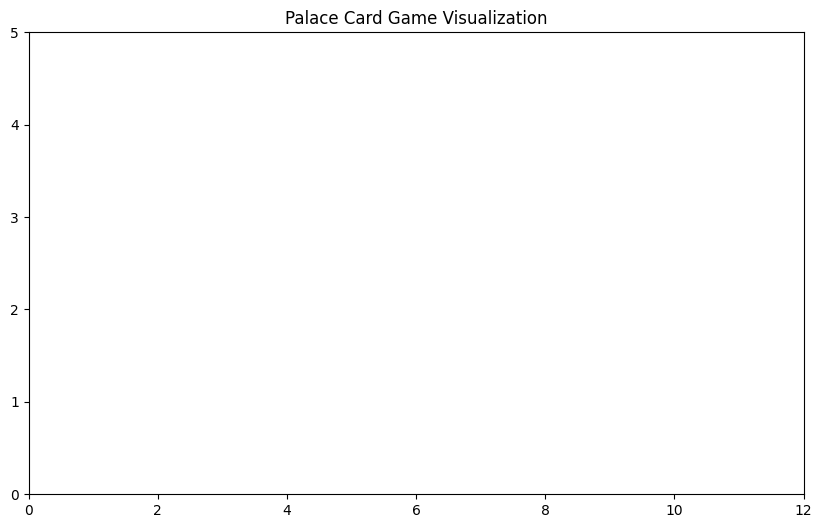

In [ ]:
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

# Define constants
SUITS = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']

# Create a deck of cards
def create_deck():
    return [f'{rank} of {suit}' for suit in SUITS for rank in RANKS]

# Shuffle deck
def shuffle_deck(deck):
    random.shuffle(deck)

# Simulate a game step
def simulate_game_step(player_hand, discard_pile, action, deck):
    """Simulate a game step by performing an action."""
    if action == 'play':
        if player_hand:  # Check if player has cards to play
            card_played = random.choice(player_hand)
            player_hand.remove(card_played)
            discard_pile.append(card_played)
        else:
            return player_hand, discard_pile, deck, 'pass'  # If no cards to play, pass
    elif action == 'draw':
        if deck:  # Check if there are cards left to draw
            card_drawn = deck.pop()
            player_hand.append(card_drawn)
        else:
            return player_hand, discard_pile, deck, 'pass'  # If deck is empty, pass
    elif action == 'pass':
        pass  # Do nothing
    return player_hand, discard_pile, deck, action

# Function to simulate a complete game and generate a dataset
def simulate_game(player_count=4, game_length=20):
    deck = create_deck()
    shuffle_deck(deck)

    hands = {f'Player_{i}': [deck.pop() for _ in range(5)] for i in range(player_count)}
    discard_pile = []

    data = []

    for turn in range(game_length):
        for player, hand in hands.items():
            # Random action: play, draw, or pass
            action = random.choice(['play', 'draw', 'pass'])
            new_hand, new_discard_pile, new_deck, applied_action = simulate_game_step(hand, discard_pile, action, deck)

            data.append({
                'turn': turn,
                'player': player,
                'player_hand': ' '.join(new_hand),
                'discard_pile': ' '.join(new_discard_pile),
                'action': applied_action,
                'remaining_deck': len(new_deck)
            })

            hands[player] = new_hand
            discard_pile = new_discard_pile
            deck = new_deck

    return data

# Save dataset to .pkl file
def save_dataset_to_pkl(dataset, filename='game_dataset.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)
    print(f"Dataset saved to {filename}")

# Load dataset from .pkl file
def load_dataset_from_pkl(filename='game_dataset.pkl'):
    try:
        with open(filename, 'rb') as f:
            dataset = pickle.load(f)
        print(f"Dataset loaded from {filename}")
        return dataset
    except FileNotFoundError:
        print(f"File {filename} not found. Please generate the dataset first.")
        return None

# Visualization using matplotlib
def visualize_game(data):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Card dimensions
    card_width = 1.2
    card_height = 1.5

    def draw_card(ax, x, y, card_text):
        rect = patches.Rectangle((x, y), card_width, card_height, linewidth=1, edgecolor='black', facecolor='lightblue')
        ax.add_patch(rect)
        ax.text(x + 0.5, y + 0.75, card_text, ha='center', va='center', fontsize=10, color='black')

    def draw_hand(player, hand, y_position):
        x_position = 0
        for card in hand:
            draw_card(ax, x_position, y_position, card)
            x_position += card_width + 0.2
        ax.text(x_position + 0.5, y_position + card_height + 0.2, player, ha='center', va='center', fontsize=12, color='black')

    # Initialize plot
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 5)
    ax.set_title("Palace Card Game Visualization")

    turn_idx = 0

    def update(frame):
        ax.clear()  # Clear previous frame
        ax.set_xlim(0, 12)
        ax.set_ylim(0, 5)
        ax.set_title("Palace Card Game Visualization")

        turn_data = data[frame]
        player = turn_data['player']
        player_hand = turn_data['player_hand'].split(' ')  # Convert string back to list
        draw_hand(player, player_hand, y_position=3)

        # Draw the discard pile
        discard_pile = turn_data['discard_pile'].split(' ')
        x_pos = 0
        for card in discard_pile:
            draw_card(ax, x_pos, 0, card)
            x_pos += card_width + 0.2

        # Update turn info
        ax.text(6, 4.5, f"Turn: {frame + 1} - {player}'s Action: {turn_data['action']}", ha='center', va='center', fontsize=12, color='black')

    ani = FuncAnimation(fig, update, frames=len(data), repeat=False, interval=1000)
    plt.show()

# Generate the game data (simulate 5 games for example)
game_data = simulate_game(player_count=2, game_length=10)

# Save the dataset to a pickle file
save_dataset_to_pkl(game_data, 'game_dataset.pkl')

# Load dataset from .pkl file (optional)
loaded_data = load_dataset_from_pkl('game_dataset.pkl')

# If loaded successfully, visualize the game
if loaded_data is not None:
    visualize_game(loaded_data)


In [ ]:
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

# Define constants
SUITS = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']

# Create a deck of cards
def create_deck():
    return [f'{rank} of {suit}' for suit in SUITS for rank in RANKS]

# Shuffle deck
def shuffle_deck(deck):
    random.shuffle(deck)

# Simulate a game step
def simulate_game_step(player_hand, discard_pile, action, deck):
    """Simulate a game step by performing an action."""
    if action == 'play':
        if player_hand:  # Check if player has cards to play
            card_played = random.choice(player_hand)
            player_hand.remove(card_played)
            discard_pile.append(card_played)
        else:
            return player_hand, discard_pile, deck, 'pass'  # If no cards to play, pass
    elif action == 'draw':
        if deck:  # Check if there are cards left to draw
            card_drawn = deck.pop()
            player_hand.append(card_drawn)
        else:
            return player_hand, discard_pile, deck, 'pass'  # If deck is empty, pass
    elif action == 'pass':
        pass  # Do nothing
    return player_hand, discard_pile, deck, action

# Function to simulate a complete game and generate a dataset
def simulate_game(player_count=4, game_length=20):
    deck = create_deck()
    shuffle_deck(deck)

    # Initialize hands for players
    hands = {f'Player_{i}': [deck.pop() for _ in range(5)] for i in range(player_count)}
    discard_pile = []

    data = []

    for turn in range(game_length):
        for player, hand in hands.items():
            # Display current state
            print(f"\nTurn {turn + 1}, {player}'s turn")
            print(f"Your hand: {hand}")
            print(f"Discard pile: {discard_pile}")
            print(f"Remaining deck size: {len(deck)}")

            # Get player action
            action = input(f"Choose an action (play, draw, pass): ").strip().lower()
            while action not in ['play', 'draw', 'pass']:
                action = input(f"Invalid action! Choose 'play', 'draw', or 'pass': ").strip().lower()

            # Apply the action to the game state
            new_hand, new_discard_pile, new_deck, applied_action = simulate_game_step(hand, discard_pile, action, deck)

            # Append data
            data.append({
                'turn': turn,
                'player': player,
                'player_hand': ' '.join(new_hand),
                'discard_pile': ' '.join(new_discard_pile),
                'action': applied_action,
                'remaining_deck': len(new_deck)
            })

            # Update the hands and deck
            hands[player] = new_hand
            discard_pile = new_discard_pile
            deck = new_deck

    return data

# Save the game dataset as a .pkl file
def save_game_data(filename='game_dataset.pkl'):
    game_data = simulate_game(player_count=2, game_length=10)  # Simulate 10 turns for 2 players
    with open(filename, 'wb') as f:
        pickle.dump(game_data, f)

# Load the game dataset from a .pkl file
def load_game_data(filename='game_dataset.pkl'):
    with open(filename, 'rb') as f:
        game_data = pickle.load(f)
    return game_data

# Visualization using matplotlib
def visualize_game(data):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Card dimensions
    card_width = 1.2
    card_height = 1.5

    def draw_card(ax, x, y, card_text):
        rect = patches.Rectangle((x, y), card_width, card_height, linewidth=1, edgecolor='black', facecolor='lightblue')
        ax.add_patch(rect)
        ax.text(x + 0.5, y + 0.75, card_text, ha='center', va='center', fontsize=10, color='black')

    def draw_hand(player, hand, y_position):
        x_position = 0
        for card in hand:
            draw_card(ax, x_position, y_position, card)
            x_position += card_width + 0.2
        ax.text(x_position + 0.5, y_position + card_height + 0.2, player, ha='center', va='center', fontsize=12, color='black')

    # Initialize plot
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 5)
    ax.set_title("Palace Card Game Visualization")

    turn_idx = 0

    def update(frame):
        ax.clear()  # Clear previous frame
        ax.set_xlim(0, 12)
        ax.set_ylim(0, 5)
        ax.set_title("Palace Card Game Visualization")

        turn_data = data[frame]
        player = turn_data['player']
        player_hand = turn_data['player_hand'].split(' ')  # Convert string back to list
        draw_hand(player, player_hand, y_position=3)

        # Draw the discard pile
        discard_pile = turn_data['discard_pile'].split(' ')
        x_pos = 0
        for card in discard_pile:
            draw_card(ax, x_pos, 0, card)
            x_pos += card_width + 0.2

        # Update turn info
        ax.text(6, 4.5, f"Turn: {frame + 1} - {player}'s Action: {turn_data['action']}", ha='center', va='center', fontsize=12, color='black')

    ani = FuncAnimation(fig, update, frames=len(data), repeat=False, interval=1000)
    plt.show()

# Save game data to .pkl file
save_game_data('game_dataset.pkl')

# Load game data from .pkl file
game_data = load_game_data('game_dataset.pkl')

# Visualize the game
visualize_game(game_data)



Turn 1, Player_0's turn
Your hand: ['A of Clubs', '5 of Hearts', 'J of Diamonds', '7 of Clubs', '8 of Clubs']
Discard pile: []
Remaining deck size: 42
Choose an action (play, draw, pass): draw

Turn 1, Player_1's turn
Your hand: ['3 of Diamonds', '4 of Diamonds', 'Q of Clubs', '8 of Diamonds', '3 of Hearts']
Discard pile: []
Remaining deck size: 41
Choose an action (play, draw, pass): draw

Turn 2, Player_0's turn
Your hand: ['A of Clubs', '5 of Hearts', 'J of Diamonds', '7 of Clubs', '8 of Clubs', '5 of Clubs']
Discard pile: []
Remaining deck size: 40
Choose an action (play, draw, pass): draw

Turn 2, Player_1's turn
Your hand: ['3 of Diamonds', '4 of Diamonds', 'Q of Clubs', '8 of Diamonds', '3 of Hearts', '4 of Spades']
Discard pile: []
Remaining deck size: 39
Choose an action (play, draw, pass): play

Turn 3, Player_0's turn
Your hand: ['A of Clubs', '5 of Hearts', 'J of Diamonds', '7 of Clubs', '8 of Clubs', '5 of Clubs', '8 of Hearts']
Discard pile: ['3 of Hearts']
Remaining dec

KeyboardInterrupt: Interrupted by user